## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers.

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[MASK]` she `[MASK]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[MASK]` she `[MASK]`. [SEP] Dwight, you ignorant `[MASK]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the encoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Contents
1. BERT from scratch: I'll show you the whole pretraining process from scratch.

2. Sentiment Analysis with BERT: I'll show you the fine-tuning process using the Huggingface package.

# 1. BERT from scratch

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import LayerNorm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam

import math
import tqdm
import random
import pickle
from collections import Counter

import warnings
warnings.filterwarnings(action='ignore')

## Sample corpus

Your corpus should be prepared with two tokenized sentences in one line with (' < : : : : > ') separator.

Eg. Wel ##come to the jungle < : : : : > I can stay here all night\n

I brought the dataset from here https://github.com/google-research-datasets/wiki-split. The original dataset have already been tokenized on punctuation, but I  do the tokenization one more using PreTrainedTokenizer from Huggingface. I will try to use this as a dataset for pretraining: the purpose of this section is to understand BERT, not pretrain BERT well!

In [ ]:
!wget https://www.dropbox.com/s/eetjpxuhno2lvle/sample_tokenized.txt

## Making dataset for pretraining

In [ ]:
class Vocab():                                                       
    def __init__(self, counter, max_size=None, min_freq=1, specials=["<PAD>", "<UNK>", "<SEP>", "<CLS>", "<MASK>"]):                 
        self.freqs = counter        
        counter = counter.copy()    
        min_freq = max(min_freq, 1)  

        self.itos = list(specials)
        # frequencies of special tokens are not counted when building vocabulary
        # in frequency order
        for tok in specials:
            del counter[tok]      


        max_size = None if max_size is None else max_size + len(self.itos)

        # sort by frequency, then alphabetically
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])     
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)            

        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:          
                break
            self.itos.append(word)            

        # stoi is simply a reverse dict for itos
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}


    def __len__(self):
        return len(self.itos)



# Building Vocab with text files
class WordVocab(Vocab):
    def __init__(self, texts, max_size=None, min_freq=1):     
        print("Building Vocab")
        self.pad_index = 0
        self.unk_index = 1
        self.sep_index = 2
        self.cls_index = 3
        self.mask_index = 4
        counter = Counter()
        for line in tqdm.tqdm(texts):      
            if isinstance(line, list):    
                words = line
            else:
                words = line.replace("\n", "").replace(" < : : : : > ", " ").split()

            for word in words:
                counter[word] += 1
        super().__init__(counter, max_size=max_size, min_freq=min_freq, specials=["<PAD>", "<UNK>", "<SEP>", "<CLS>", "<MASK>"])         
   

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)


    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)


In [ ]:
with open('sample_tokenized.txt', "r", encoding="utf-8") as f:
    vocab = WordVocab(f, max_size=None, min_freq=10)

print("VOCAB SIZE:", len(vocab))
vocab.save_vocab('sample_vocab.pkl')

3513it [00:00, 35127.52it/s]

Building Vocab


989944it [00:27, 36657.32it/s]


VOCAB SIZE: 27865


In [ ]:
vocab = WordVocab.load_vocab('sample_vocab.pkl')   

In [ ]:
print(vocab.pad_index)
print(vocab.unk_index)
print(vocab.sep_index)
print(vocab.cls_index)
print(vocab.mask_index)

0
1
2
3
4


In [ ]:
vocab.itos[:10]

['<PAD>', '<UNK>', '<SEP>', '<CLS>', '<MASK>', 'the', '.', ',', "'", 'of']

In [ ]:
vocab.stoi;

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, corpus_path, vocab, seq_len, encoding="utf-8",):         # seq_len: The seq length you set 
        self.vocab = vocab
        self.seq_len = seq_len
        self.corpus_path = corpus_path
        self.encoding = encoding

        with open(corpus_path, "r", encoding=self.encoding) as f:
            self.lines = [line[:-1].split(" < : : : : > ")                                 # self.lines: [[sent1A, sent1B], [sent2A, sent2B], ...[sent15A, sent15B]]
                          for line in tqdm.tqdm(f, desc="Loading Dataset")]          
            self.corpus_lines = len(self.lines)


    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):      
        t1, t2, is_next_label = self.random_sent(item)       # 'item'th row sentences in the corpus, but the second sentence is randomly replaced. t1 and t2: str, is_next_label: 0(isNotNext) or 1(isNext)
        t1_random, t1_label = self.random_word(t1)           # t1_random does not contain <CLS>, <SEP> index yet.
        t2_random, t2_label = self.random_word(t2)           # t2_random does not contain <CLS>, <SEP> index yet.

        t1 = [self.vocab.cls_index] + t1_random + [self.vocab.sep_index]        # [3, ..., 2]
        t2 = t2_random + [self.vocab.sep_index]                                 # [..., 2]

        t1_label = [self.vocab.pad_index] + t1_label + [self.vocab.pad_index]   # [0, ..., 0]
        t2_label = t2_label + [self.vocab.pad_index]                            # [..., 0]

        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]   # [1, 1, 1 ,1 ,1, 2, 2, 2, 2, 2] 
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]                       

        padding = [self.vocab.pad_index for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)     # making 'self.seq_len'-length list with padding

        output = {"bert_input": bert_input,             
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}      # Return after conversion to torch.tensor    final output: dict

    def random_word(self, sentence): # sentence: str
        # make token index list for input 'sentence' 
        # some tokens has to be masked
        tokens = sentence.split()    
        output_label = []

        for i, token in enumerate(tokens):
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8:
                    tokens[i] = self.vocab.mask_index              

                # 10% randomly change token to random token
                elif prob < 0.9:                                  
                    tokens[i] = random.randrange(len(self.vocab))  

                # 10% randomly change token to current token. Randomly 10% of tokens, will be remain as same. But need to be predicted.
                else:
                    tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)     

                output_label.append(self.vocab.stoi.get(token, self.vocab.unk_index))   # masked token's output label: original token index(answer)

            else:
                tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)    # contain the index corresponding to word(token) in 'tokens' list. If not, contain unk_index(1).
                output_label.append(0)                                          # not-masked token's output label: 0

        return tokens, output_label    

    def random_sent(self, index):       # index means 'index'th row in corpus
        t1, t2 = self.get_corpus_line(index)

        # output_text, label(isNotNext:0, isNext:1)
        if random.random() > 0.5:  
            return t1, t2, 1            # correct pair. label: 1
        else:                       
            return t1, self.get_random_line(), 0    # random pair. label: 0

    def get_corpus_line(self, item):   # item means 'item'th row in corpus
        return self.lines[item][0], self.lines[item][1]    # output t1, t2: str
          

    def get_random_line(self):       # Select any line in the corpus and get the sencond sentence
        return self.lines[random.randrange(len(self.lines))][1]    # output t2: str

In [ ]:
### For your understanding
train_dataset = BERTDataset(corpus_path='sample_tokenized.txt', vocab=vocab, seq_len=128)

Loading Dataset: 989944it [00:05, 188051.21it/s]


In [ ]:
train_dataset.__len__()

989944

In [ ]:
train_dataset.__getitem__(0)

{'bert_input': tensor([    3,     4,     4,     4,    19,    33, 14862,    29,    45,   561,
            13,     4,     7,    33,  2188,  4752,   858,     5,  7195,     4,
           116,    11,  4878,    10,   226,    31,   115,     4,    13,     5,
           162,    10,   829,     6,     2,    19,     5,    49,   117,     4,
            25,  5373,  3729,     7,     4,  8428,  8306, 17457,     6,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Buliding the BERT Model class

In [ ]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):                         # query, key, value: (B, h, seq_len, d_k) eg.(B, 12, seq_len, 64)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))    # torch.transpose(input, dim0, dim1): The given dimensions dim0 and dim1 are swapped.
                                                                                           # scores: (B, h, seq_len, seq_len) 
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)                        # masked_fill(mask, value): Fills elements of self tensor with value where mask is True. 
                                                                               
        p_attn = F.softmax(scores, dim=-1)                                      # p_attn: (B, h, seq_len, seq_len) 

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn                              # torch.matmul(p_attn, value): (B, h, seq_len, d_k), p_attn: (B, h, seq_len, seq_len)
                                                                                

class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.(d_model, h)
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0                                                 

        # We assume d_v always equals d_k
        self.d_k = d_model // h                                                 # eg. d_model = 768, h = 12, d_k = 64
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])  # 3 linear layer. WQ, WK, WV   eg.(768, 768(64 x 12))
        self.output_linear = nn.Linear(d_model, d_model)                        # 768->768
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):                            # input query, key, value will be x with (B, seq_len, d_model). 
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model -> h x d_k     eg. 768 -> (12, 64)
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)  # l(x): (B, seq_len, d_model) -> (B, seq_len, h, d_k) -> (B, h, seq_len, d_k) 
                             for l, x in zip(self.linear_layers, (query, key, value))]    # output: (B, h, seq_len, d_k)  eg.(B, 12, seq_len, 64)

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)     # x:(B, h, N, d_k) eg.(B, 12, seq_len, 64), attn:(B, h, seq_len, seq_len) eg.(B, 12, seq_len, seq_len)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)    # x:(B, h, seq_len, d_k) -> (B, seq_len, h, d_k)  -> (B, seq_len, h * d_k)  eg.(B, seq_len, 768)
                                                                                      # When you call contiguous(), it actually makes a copy of tensor so the order of elements would be same as if tensor of same shape created from scratch. Normally you don't need to worry about this. 
                                                                                      # https://stackoverflow.com/questions/48915810/pytorch-contiguous
        return self.output_linear(x)                                                  # final output: (B ,seq_len, d_model) eg.(B, seq_len, 768) 

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):                                          #  size :  eg. 768
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):                                             # the input 'sublayer' will be Multihead attention or FF
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))                         

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)                                     # d_ff: d_model x 4,  eg. 768 x 4 = 3072
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):                                                       # x: (B, seq_len, d_model)
        return self.w_2(self.dropout(self.activation(self.w_1(x))))             # (B, seq_len, d_model)

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):           # x: (B, seq_len, hidden)   eg.(B, seq_len, 768)
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))    
        x = self.output_sublayer(x, self.feed_forward)                                            
        return self.dropout(x)            # (B, seq_len, hidden)      

In [ ]:
class TokenEmbedding(nn.Embedding):                                             # torch.nn.Embedding(vocab_size, embedding_dim, padding_idx)
    def __init__(self, vocab_size, embed_size=512):                             # padding_idx=0 means 0th row in the embeding matrix is 0 vector.
        super().__init__(vocab_size, embed_size, padding_idx=0)


class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()                              # pe: (max_len, d_model)
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)                                  # (max_len, 1)  eg. (512, 1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()   # (d_model//2,) eg. (384,)
        a = position * div_term                                                                   # (max_len, d_model//2)  eg. (512, 384)
        pe[:, 0::2] = torch.sin(a)                            # seq = L[start:stop:step]    0::2 start 0, step_size = 2  
        pe[:, 1::2] = torch.cos(a)                            

        pe = pe.unsqueeze(0)                                                    # pe: (1, max_len, d_model)
        self.register_buffer('pe', pe)                                          # Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them.
                                                                                # register_buffer(name, tensor)
    def forward(self, x):                         # x: (B, seq_len)
        return self.pe[:, :x.size(1)]             # (1, seq_len, d_model)


class SegmentEmbedding(nn.Embedding):
    def __init__(self, embed_size=512):
        super().__init__(3, embed_size, padding_idx=0)                          #0(padding), 1(first sentence), 2(second sentence)


class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, dropout=0.1):                    # embed_size: eg. 768     
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, segment_label):    # sequence: (B, seq_len), segment_label: (B, seq_len)
        ### quiz
        # make BERT Embedding using token embedding, position embedding, and segment embedding                                          
        x =  ???                                      # (B, seq_len, hidden), (1, seq_len, hidden), (B, seq_len, hidden), respectively. Broadcasting;  
        return self.dropout(x)

In [ ]:
class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):                                         # x: (B, seq_len),      segment_info: (B, seq_len)
        
        # attention masking for padded token
        # attention mask size: torch.ByteTensor([batch_size, 1, seq_len, seq_len])  Why? Because of 'scores' shape in Attention class: (B, h, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)        # (B, seq_len) -> (B, 1, seq_len) -> (B, seq_len, seq_len) -> (B, 1, seq_len, seq_len)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

In [ ]:
### For your understanding
bert = BERT(len(vocab), hidden=768)
x = torch.tensor([[3, 19, 4, 2, 7, 7, 2, 0, 0, 0],               # (2, 10) 2=Batch_size, 10=seq_len 
                  [3, 8, 7, 4, 2, 5, 6, 8, 2, 0]])
segment_info = torch.tensor([[1, 1, 1, 1, 2, 2, 2, 0, 0, 0],     # (2, 10)          
                             [1, 1, 1, 1, 1, 2, 2, 2, 2, 0]])


### quiz
# if size of input x is (2, 10), what is the output y size?
y = 


''

In [ ]:
### quiz
#Calculate the number of parameters of 'bert' above.

print("Total Parameters:", )

''

## Building the BERT Trainer class

In [ ]:
class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.hidden)      # bert.hidden = eg. 768
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x, segment_label):                   # x: (B, seq_len),      segment_label: (B, seq_len)
        x = self.bert(x, segment_label)                    # x: (B, seq_len, hidden)
        return self.next_sentence(x), self.mask_lm(x)      # self.next_sentence(x): (B, 2), self.mask_lm(x): (B, seq_len, vocab_size)


### quiz
# Fill in the blanks.
class NextSentencePrediction(nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = ???    
        self.softmax = ???            

    def forward(self, x):
        return ???             # we use the first token <CLS> for the NSP.
                                                           

class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model  eg.768
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = ???
        self.softmax = ???

    def forward(self, x):
        return ???                

In [ ]:
class BERTTrainer:
    """
    BERTTrainer make the pretrained BERT model with two LM training method.
        1. Masked Language Model : 3.3.1 Task #1: Masked LM
        2. Next Sentence prediction : 3.3.2 Task #2: Next Sentence Prediction
    """

    def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, test_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01,
                 with_cuda: bool = True, log_freq: int = 10, do_NSP=True):
        """
        :param bert: BERT model which you want to train
        :param vocab_size: total word vocab size
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: learning rate of optimizer
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param with_cuda: traning with cuda
        :param log_freq: printing loss every n iter
        """

        # Setup cuda device for BERT training, with_cuda should be true
        cuda_condition = torch.cuda.is_available() and with_cuda
        self.device = torch.device("cuda:0" if cuda_condition else "cpu")

        # This BERT model will be saved every epoch
        self.bert = bert
        # Initialize the BERT Language Model, with BERT model
        self.model = BERTLM(bert, vocab_size).to(self.device)

        # Setting the train and test data loader
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion_MLM = nn.NLLLoss(ignore_index=0)        # ignore_index=0 i.e., We don't need to predict the not-masked tokens
                                                               # ignore_index: Specifies a target value that is ignored and does not contribute to the input gradient.
        self.criterion_NSP = nn.NLLLoss()
        
        self.log_freq = log_freq
        
        self.do_NSP = do_NSP

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        """
        loop over the data_loader for training or testing
        if on train status, backward operation is activated
        and also auto save the model every peoch
        :param epoch: current epoch index
        :param data_loader: torch.utils.data.DataLoader for iteration
        :param train: boolean value of is train or test
        :return: None
        """
        str_code = "train" if train else "test"

        for i, data in enumerate(data_loader):
            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {k: v.to(self.device) for k, v in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])     # data["bert_input"], data["segment_label"]: (B, seq_len)
                                                                                                                 # next_sent_output: (B, 2)  mask_lm_output: (B, seq_len, vocab_size)
            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion_NSP(next_sent_output, data["is_next"])                    # data["is_next"]: (B,)

            # 2-2. NLLLoss of predicting masked token word
            mask_loss = self.criterion_MLM(mask_lm_output.transpose(1, 2), data["bert_label"])   # mask_lm_output.transpose(1, 2): (B, vocab_size, seq_len)    data["bert_label"]: (B, seq_len)   

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            
            if self.do_NSP:
                loss = next_loss + mask_loss
            else:
                loss = mask_loss

            # 3. backward and optimization only in train
            if train:                                                           
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            if i % self.log_freq == 0:
                print("EP%d_%s[%d/%d]"%(epoch, str_code, i, len(data_loader)), "total_loss=", loss.item(), 
                      "MLM_Loss=", mask_loss.item(), "NSP_loss=", next_loss.item())


    def save(self, epoch, file_path="bert_trained.model"):
        """
        Saving the current BERT model on file_path
        :param epoch: current epoch number
        :param file_path: model output path which gonna be file_path+"ep%d" % epoch
        :return: final_output_path
        """
        output_path = file_path + ".ep%d" % epoch
        torch.save(self.bert.cpu(), output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)

## Let's define train function

In [ ]:
def train(train_dataset, vocab_path, output_path, test_dataset=None,
          hidden=768, layers=12, attn_heads=12, seq_len=128, 
          batch_size=32, epochs=5, num_workers=4,
          with_cuda=True, log_freq=10, 
          lr=1e-4, adam_weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999,
          do_NSP=True):
    """
    Arguments:
      train_dataset: train dataset for train bert, type=str 
      test_dataset: test set for evaluate train set, type=str
      vocab_path: built vocab model path with bert-vocab, type=str
      output_path: ex)output/bert.model, type=str

      hidden: hidden size of transformer model
      layers: number of layers
      attn_heads: number of attention heads
      seq_len: maximum sequence len

      batch_size: number of batch_size
      epochs: number of epochs
      num_workers: dataloader worker size

      with_cuda: training with CUDA: true, or false
      log_freq: printing loss every n iter: setting n

      lr: learning rate of adam
      adam_weight_decay: weight_decay of adam
      adam_beta1: adam first beta value
      adam_beta2: adam first beta value
    """

    print("Loading Vocab", vocab_path)
    vocab = WordVocab.load_vocab(vocab_path)
    print("Vocab Size: ", len(vocab))

    print("Loading Train Dataset", train_dataset)
    train_dataset = BERTDataset(train_dataset, vocab, seq_len=seq_len)

    print("Loading Test Dataset", test_dataset)
    test_dataset = BERTDataset(test_dataset, vocab, seq_len=seq_len) \
        if test_dataset is not None else None

    print("Creating Dataloader")
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers) \
        if test_dataset is not None else None

    print("Building BERT model")
    bert = BERT(vocab_size=len(vocab), hidden=hidden, n_layers=layers, attn_heads=attn_heads, dropout=0.1)

    print("Creating BERT Trainer")
    trainer = BERTTrainer(bert, vocab_size=len(vocab), train_dataloader=train_data_loader, test_dataloader=test_data_loader,
                          lr=lr, betas=(adam_beta1, adam_beta2), weight_decay=adam_weight_decay,
                          with_cuda=with_cuda, log_freq=log_freq, do_NSP=do_NSP)

    print("Training Start")
    for epoch in range(epochs):
        trainer.train(epoch)                
        trainer.save(epoch, output_path)

        if test_data_loader is not None:
            trainer.test(epoch)

## Let's implement the code!

In [ ]:
train(train_dataset='sample_tokenized.txt', vocab_path='sample_vocab.pkl', output_path='bert_trained.model',
    test_dataset=None, hidden=512, layers=4, attn_heads=8, seq_len=128, 
    batch_size=128, epochs=1, num_workers=4,
    with_cuda=True, log_freq=1000, 
    lr=1e-5, adam_weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999,
    do_NSP = True)

Loading Dataset: 0it [00:00, ?it/s]

Loading Vocab sample_vocab.pkl
Vocab Size:  27865
Loading Train Dataset sample_tokenized.txt


Loading Dataset: 989944it [00:04, 233642.16it/s]


Loading Test Dataset None
Creating Dataloader
Building BERT model
Creating BERT Trainer
Training Start
EP0_train[0/7734] total_loss= 11.617738723754883 MLM_Loss= 10.889900207519531 NSP_loss= 0.7278386950492859
EP0_train[1000/7734] total_loss= 8.197671890258789 MLM_Loss= 7.466292858123779 NSP_loss= 0.7313792705535889
EP0_train[2000/7734] total_loss= 7.978883743286133 MLM_Loss= 7.266356945037842 NSP_loss= 0.7125267386436462
EP0_train[3000/7734] total_loss= 7.903524398803711 MLM_Loss= 7.207229137420654 NSP_loss= 0.6962953805923462
EP0_train[4000/7734] total_loss= 8.032331466674805 MLM_Loss= 7.324373722076416 NSP_loss= 0.7079573273658752
EP0_train[5000/7734] total_loss= 7.677303791046143 MLM_Loss= 6.985208034515381 NSP_loss= 0.6920956373214722
EP0_train[6000/7734] total_loss= 7.60671854019165 MLM_Loss= 6.898470401763916 NSP_loss= 0.7082481980323792
EP0_train[7000/7734] total_loss= 7.669640064239502 MLM_Loss= 6.953846454620361 NSP_loss= 0.7157934904098511
EP:0 Model Saved on: bert_trained.m

# 2. Sentiment Analysis with BERT

> In this section, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the Transformers library by Hugging Face!

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.7MB/s 
     |████████████████████████████████| 2.9MB 25.0MB/s 
     |████████████████████████████████| 1.1MB 31.4MB/s 
     |████████████████████████████████| 890kB 23.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d0d1e8a59b0bb7796f11acfff0adc41a172c18375317e02e6f1e3b404e756ee8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams    
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
!wget https://www.dropbox.com/s/or24fh5y6pogv9v/reviews.csv
df = pd.read_csv("reviews.csv")
df.head()

--2020-11-25 13:44:31--  https://www.dropbox.com/s/or24fh5y6pogv9v/reviews.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/or24fh5y6pogv9v/reviews.csv [following]
--2020-11-25 13:44:32--  https://www.dropbox.com/s/raw/or24fh5y6pogv9v/reviews.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc250fba9947fad938cb752cfbc.dl.dropboxusercontent.com/cd/0/inline/BD3C9eJ2YFhiFyvKoLgOWuePvh7iYvChgiGTEhsAqNeFcd4he63BfyJt1bZg4ZKSjrHWRoZgE1dLcYjf4jTet1jj8buAbG_JfiJfkw_GOtJQ3ZJlH5wur2k36PmbbAvG-ys/file# [following]
--2020-11-25 13:44:33--  https://ucc250fba9947fad938cb752cfbc.dl.dropboxusercontent.com/cd/0/inline/BD3C9eJ2YFhiFyvKoLgOWuePvh7iYvChgiGTEhsAqNeFcd4he63BfyJt1bZg4ZKSjrHWRoZgE1dLcYjf4jTet1jj8buAbG_JfiJfkw_GOtJQ3ZJlH5

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
userName                15746 non-null object
userImage               15746 non-null object
content                 15746 non-null object
score                   15746 non-null int64
thumbsUpCount           15746 non-null int64
reviewCreatedVersion    13533 non-null object
at                      15746 non-null object
replyContent            7367 non-null object
repliedAt               7367 non-null object
sortOrder               15746 non-null object
appId                   15746 non-null object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


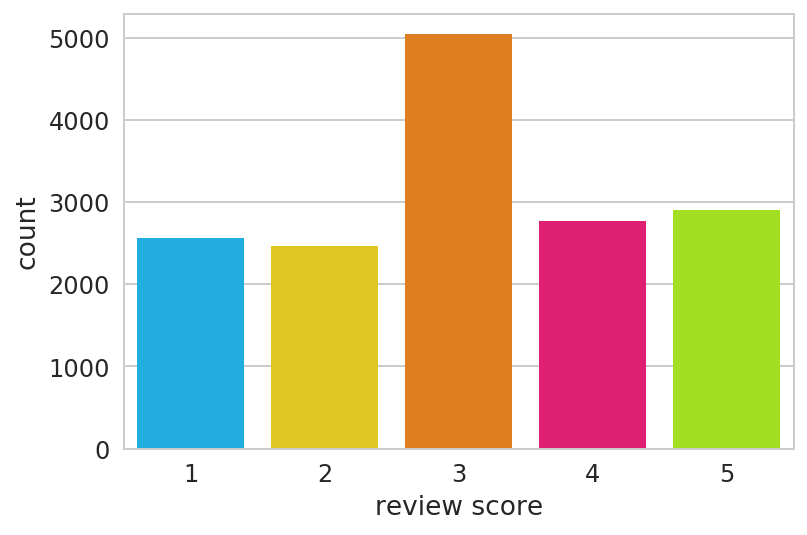

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

We're going to convert the dataset into negative, neutral and positive sentiment:

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

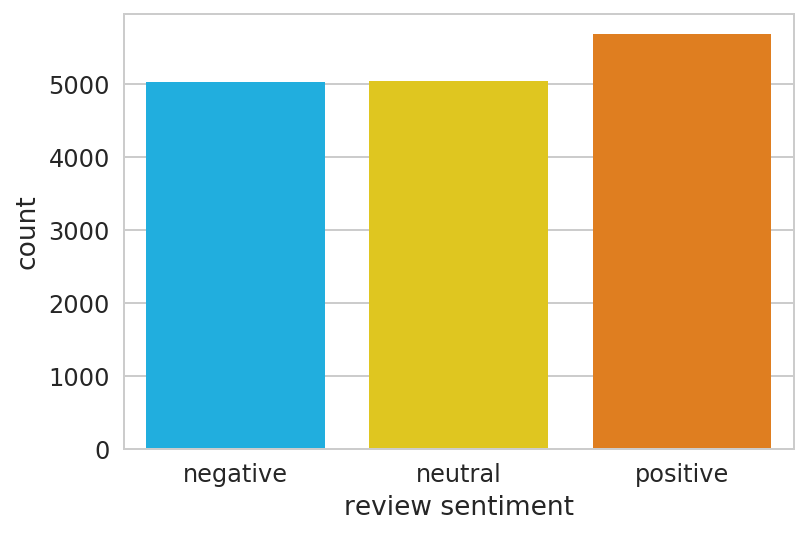

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored!

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models (including BERT). 

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

You can use a cased and uncased version of BERT and tokenizer. In this task, the cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = 'Nice to meet you. How are you?'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Nice to meet you. How are you?
   Tokens: ['Nice', 'to', 'meet', 'you', '.', 'How', 'are', 'you', '?']
Token IDs: [8835, 1106, 2283, 1128, 119, 1731, 1132, 1128, 136]


### Special Tokens

`[SEP]` - marker for ending of a sentence

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation = True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()
# trucation=True

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 8835, 1106, 2283, 1128,  119, 1731, 1132, 1128,  136,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Nice',
 'to',
 'meet',
 'you',
 '.',
 'How',
 'are',
 'you',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, truncation = True, max_length=512)   
  token_lens.append(len(tokens))

In [ ]:
tokens;

and plot the distribution:

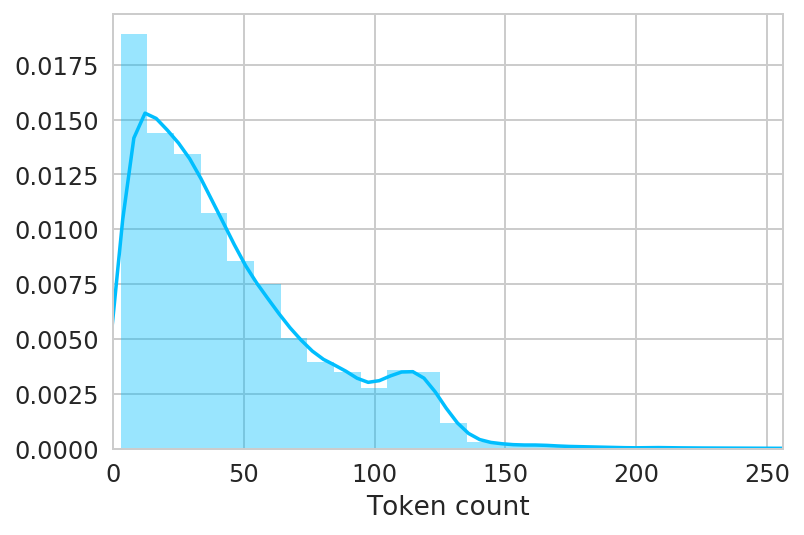

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),               # flatten(): [1, 160] -> [160]
      'attention_mask': encoding['attention_mask'].flatten(),     
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
### For your understanding
ds = GPReviewDataset(
reviews=df.content.to_numpy(),        # df.content.to_numpy().shape: (15746,)
targets=df.sentiment.to_numpy(),      # df.sentiment.to_numpy().shape: (15746,)
tokenizer=tokenizer,
max_len=160
)

In [ ]:
ds.__len__()

15746

In [ ]:
ds.__getitem__(0)['review_text']

"Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK."

In [ ]:
ds.__getitem__(0)['input_ids']    # size(): [160]

tensor([  101,  3725,  9216,   131,  1258,  2033,   170,  2593,  1121,  1103,
         9991,   146,  1156,  1849,  1139,  5261,  1106,   121,  2940,  1191,
         1936,   119,  1636,  3713,  4750,  1481, 18110,  1105, 11769, 23911,
         2538,  1105, 10250,  1106,   171, 17717,  1120,  1155,   119,   146,
          112,   182,  1177, 12049,  1115,  1139,  1948,  1144,  1151,  1575,
         1106,  1172,   106,  8762,  6434,  8132,  2541,   119,  7267,   131,
         4108,  1304,  5784,  1165,  6086,  1146,  1111,   170,  1714,  3443,
         1104,  1142, 12647,   119,  1409,  1128,  3333,  1106,  1301,  1166,
         1152,  7743,  2965,  1128,  1111,   170,  1554,  1201, 16759,  1105,
        10250,  1106,  1231, 14703,  3276,   119, 12008, 27788,  8132,  2541,
         1105,  1103, 12647,  1110,  1198, 10899,   119,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
ds.__getitem__(0)['attention_mask']    # size(): [160]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's split the dataset:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),        # df.content.to_numpy().shape: (15746,)
    targets=df.sentiment.to_numpy(),      # df.sentiment.to_numpy().shape: (15746,)
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
sample_batched = next(iter(train_data_loader))
sample_batched.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(sample_batched['input_ids'].shape)
print(sample_batched['attention_mask'].shape)
print(sample_batched['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(               # pooled_output: last_hidden_state's first token([CLS]) -> nn.Linear(config.hidden_size, config.hidden_size) -> nn.Tanh()
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.size()

torch.Size([1, 32, 768])

In [ ]:
pooled_output.size()

torch.Size([1, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768

You can think of the `pooled_output` as a summary of the content, according to BERT. 
So, we'll use `pooled_output` for the sentiment analysis.

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()                      
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))       # len(class_names): 3
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = sample_batched['input_ids'].to(device)
attention_mask = sample_batched['attention_mask'].to(device)

print(input_ids.size()) # (batch size, seq length)
print(attention_mask.size()) # (batch size, seq length)

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5879, 0.0842, 0.3279],
        [0.4308, 0.1888, 0.3804],
        [0.4871, 0.1766, 0.3363],
        [0.3364, 0.0778, 0.5858],
        [0.4025, 0.1040, 0.4935],
        [0.3599, 0.1026, 0.5374],
        [0.5054, 0.1552, 0.3394],
        [0.5962, 0.1464, 0.2574],
        [0.3274, 0.1967, 0.4759],
        [0.3026, 0.1118, 0.5856],
        [0.4103, 0.1571, 0.4326],
        [0.4879, 0.2121, 0.3000],
        [0.3811, 0.1477, 0.4712],
        [0.3354, 0.1354, 0.5292],
        [0.3999, 0.2822, 0.3179],
        [0.5075, 0.1684, 0.3242]], device='cuda:0', grad_fn=<SoftmaxBackward>)

################################# **Doing yourself from here **#################################

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)      
    loss = loss_fn(outputs, targets)          

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)  
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7235159222751385 accuracy 0.6746877425728601
Val   loss 0.5855555960536003 accuracy 0.7560355781448539

Epoch 2/10
----------
Train loss 0.4211892030006338 accuracy 0.8396020040928658
Val   loss 0.5206950922310353 accuracy 0.8398983481575604

Epoch 3/10
----------
Train loss 0.23575607756611053 accuracy 0.9232940512313881
Val   loss 0.723232996314764 accuracy 0.8462515883100381

Epoch 4/10
----------
Train loss 0.15901364872135373 accuracy 0.9520146778632419
Val   loss 0.7460412856936455 accuracy 0.8691232528589581

Epoch 5/10
----------
Train loss 0.11642625146707347 accuracy 0.9666219744548726
Val   loss 0.8364233691990376 accuracy 0.8640406607369759

Epoch 6/10
----------
Train loss 0.09107118240362096 accuracy 0.9767130054336322
Val   loss 0.8589009740948677 accuracy 0.8653113087674714

Epoch 7/10
----------
Train loss 0.06405976756515809 accuracy 0.9806647378448945
Val   loss 0.8941457891464233 accuracy 0.866581956797967

Epoch 8/10
----------
Tr

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

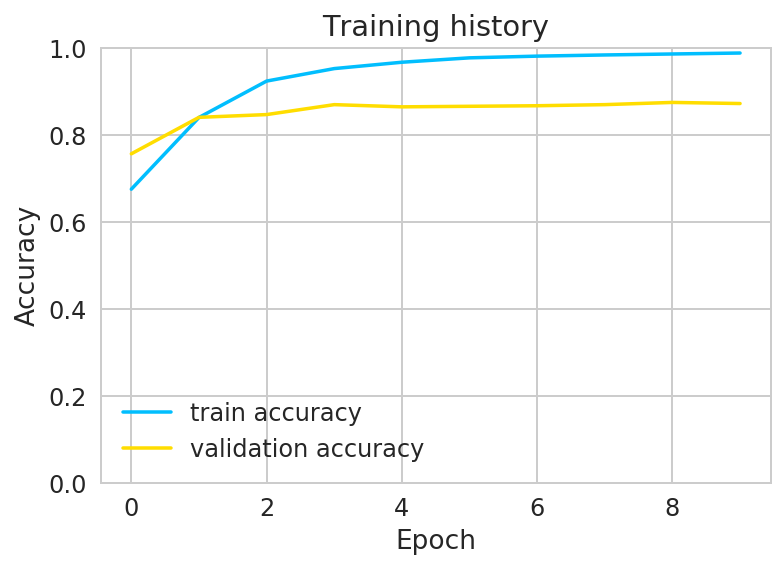

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? download my trained model:

In [ ]:
!wget https://www.dropbox.com/s/g82n1d3gl0qfycn/best_model_state.bin

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

--2020-11-25 04:29:33--  https://www.dropbox.com/s/g82n1d3gl0qfycn/best_model_state.bin
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g82n1d3gl0qfycn/best_model_state.bin [following]
--2020-11-25 04:29:33--  https://www.dropbox.com/s/raw/g82n1d3gl0qfycn/best_model_state.bin
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc076ea62e7d7b16f47573b29943.dl.dropboxusercontent.com/cd/0/inline/BD1IGOucqr2ucfuuwt0_0AAk-8EBWQpeCwQXu2LCk5NcyxKZZz--3J49zJBl_vo0TST0XjOZ08wbiOxk9DY3oPqEEC1tvxSHEZQuqeOzWKRSnc_r2Qy7VKTHWCwXtv-gdCc/file# [following]
--2020-11-25 04:29:33--  https://uc076ea62e7d7b16f47573b29943.dl.dropboxusercontent.com/cd/0/inline/BD1IGOucqr2ucfuuwt0_0AAk-8EBWQpeCwQXu2LCk5NcyxKZZz--3J49zJBl_vo0TST0XjOZ08wbiOxk9DY3oPqEEC

### Evaluation

Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8921319796954315

Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)           

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)                     
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()        
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))    

              precision    recall  f1-score   support

    negative       0.92      0.84      0.88       245
     neutral       0.84      0.89      0.86       254
    positive       0.92      0.94      0.93       289

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



Looks like it is hard to classify neutral (3 stars) reviews.
We'll continue with the confusion matrix:

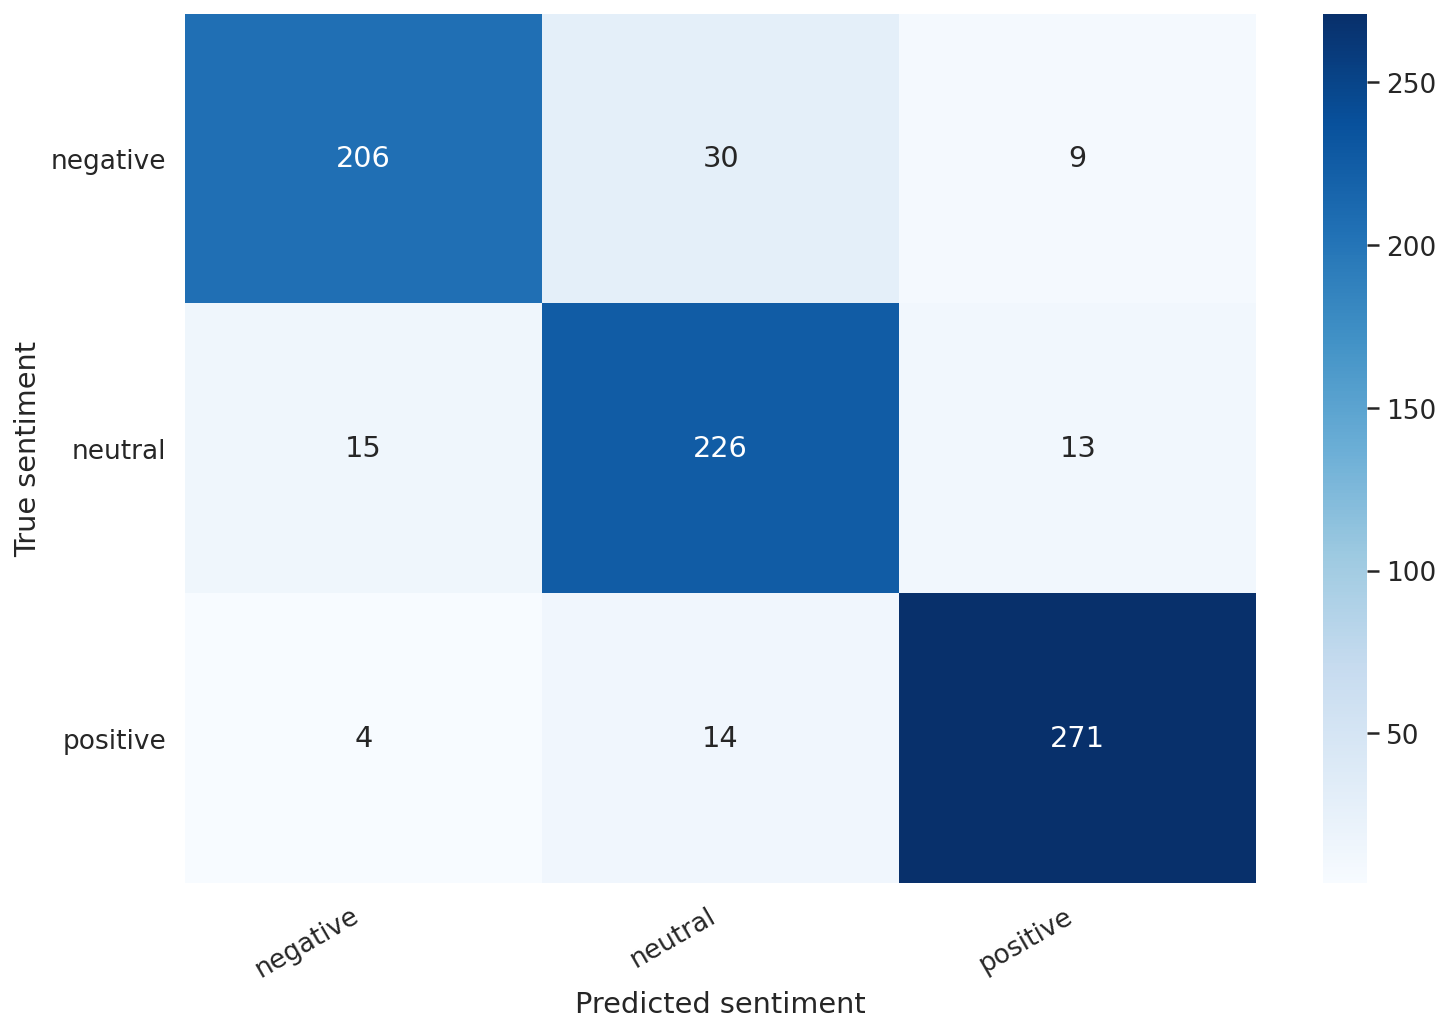

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "well, not bad"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: well, not bad
Sentiment  : neutral


# References
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [BERT implementation](https://github.com/codertimo/BERT-pytorch)